Import Libraries

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import re

Define Sub Functions

In [92]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image):
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]
    
def green_otsu_threshold(image, image_path):
    """Apply Otsu's thresholding to the image."""
    if (re.search(r'FCCP', image_path)):
        return image > 30000
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary


def red_otsu_threshold(image):
    """Apply Otsu's thresholding to the image."""
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary



def mask_near_border(mask, distance=75):
    """Checks if a binary mask comes within a specified distance of the TOP or RIGHT image borders.

    Args:
        mask: A numpy array representing the binary mask (0s and 1s).
        distance: The distance from the border to check (default: 75 pixels).

    Returns:
        True if the mask touches the top or right border within 'distance', False otherwise.
    """
    # Check TOP edge (first 'distance' rows)
    if np.any(mask[:distance, :]):  
        return True
    # Check RIGHT edge (last 'distance' columns)
    if np.any(mask[:, -distance:]):  
        return True
    return False

Main Function

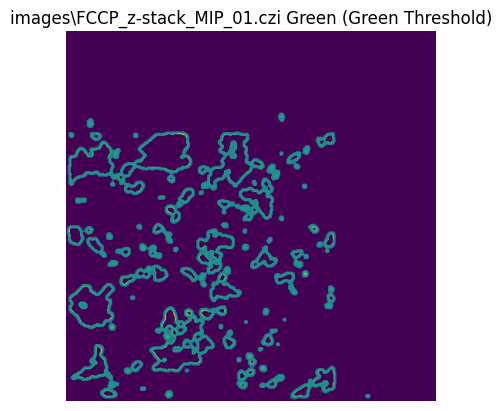

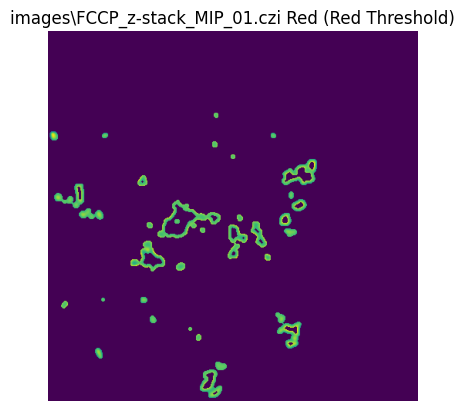

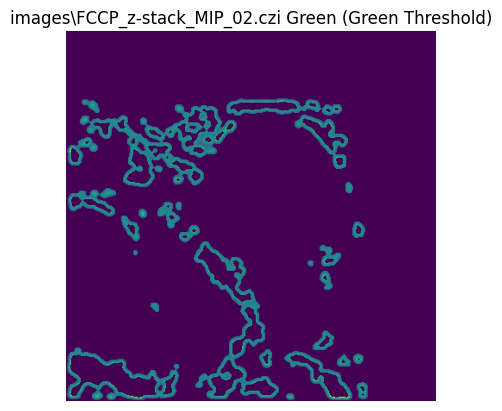

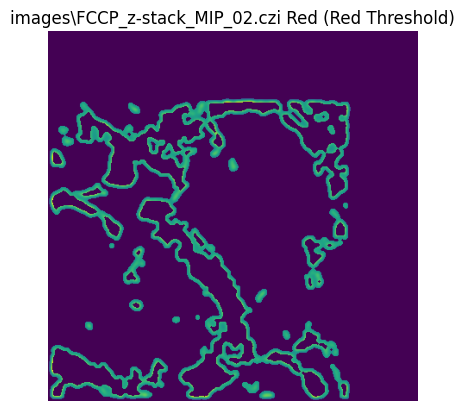

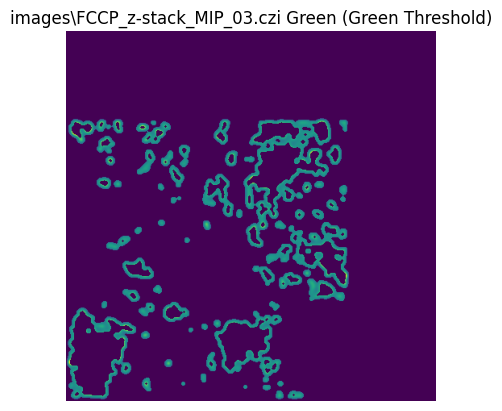

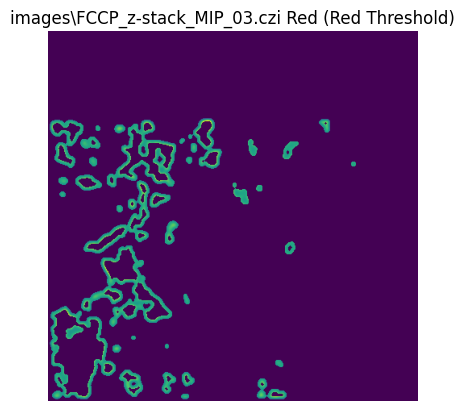

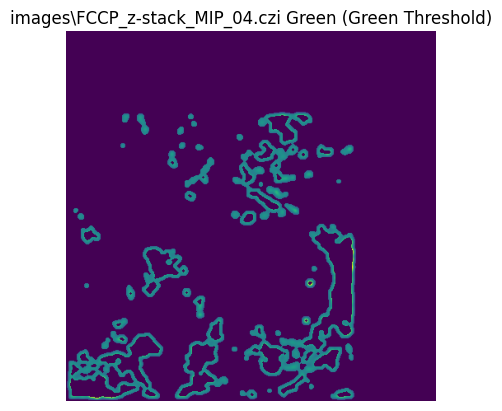

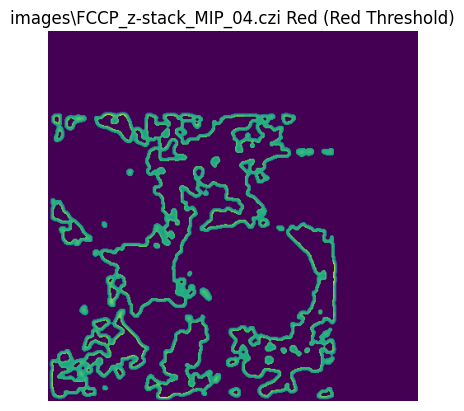

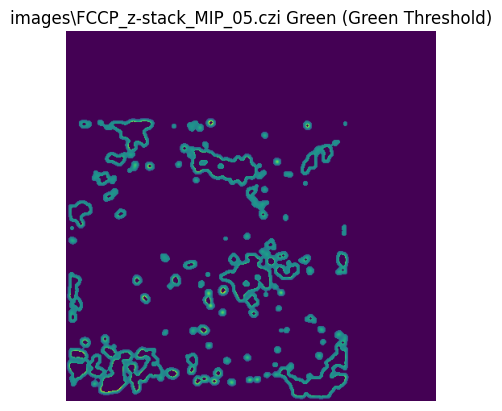

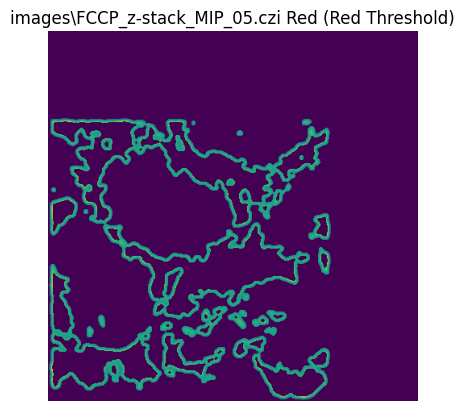

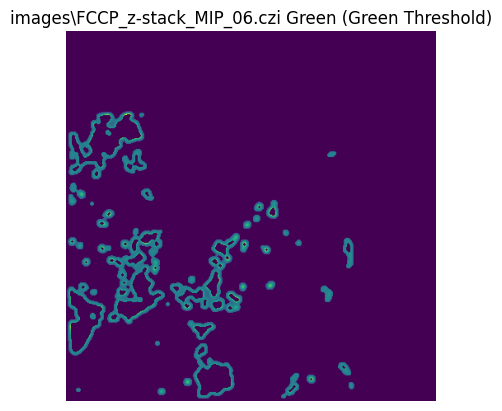

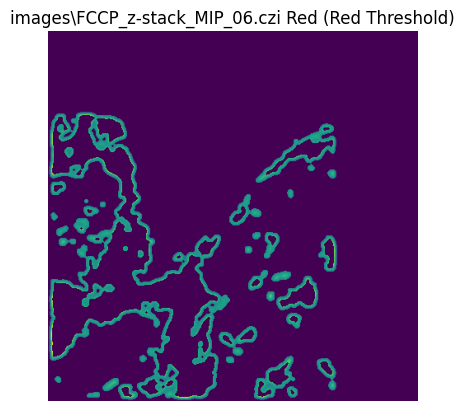

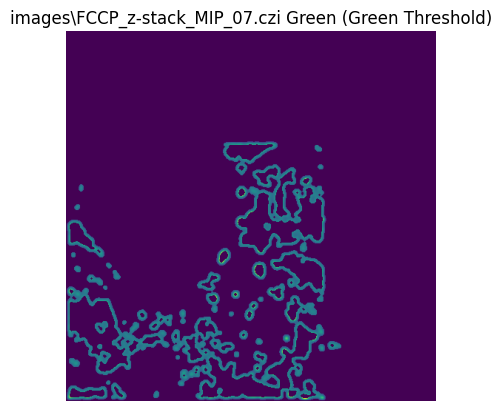

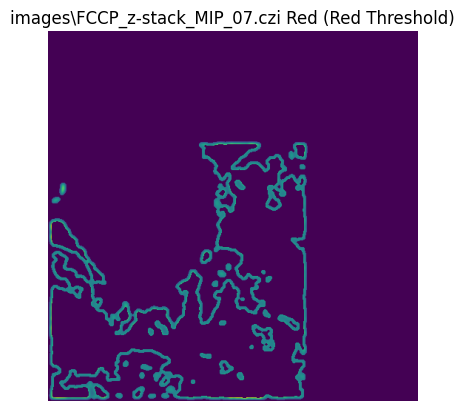

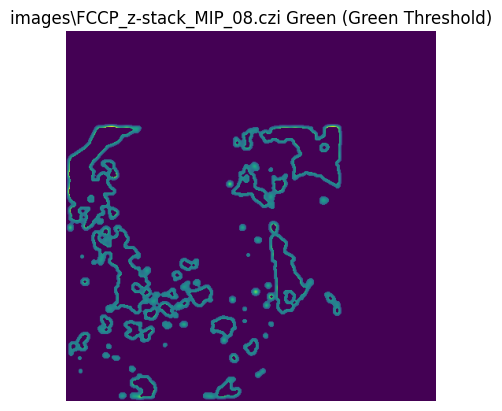

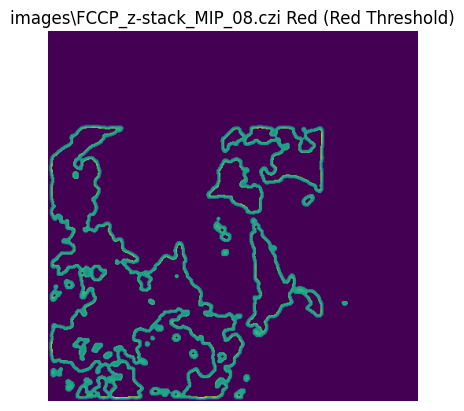

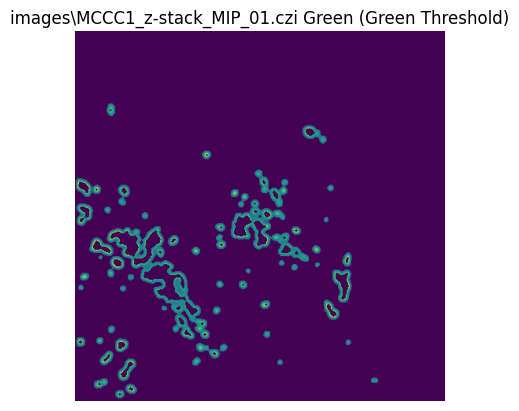

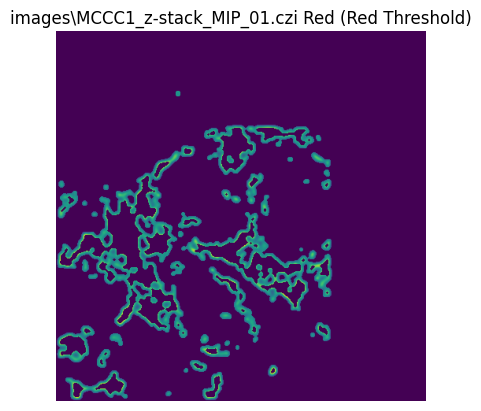

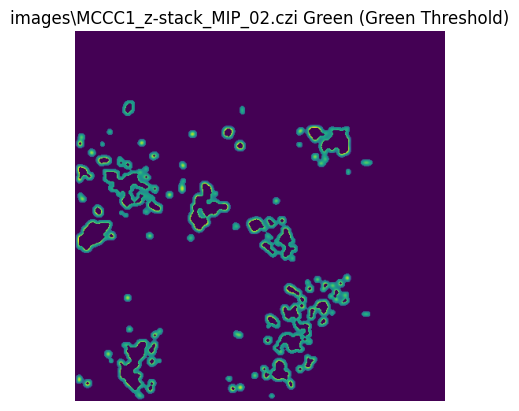

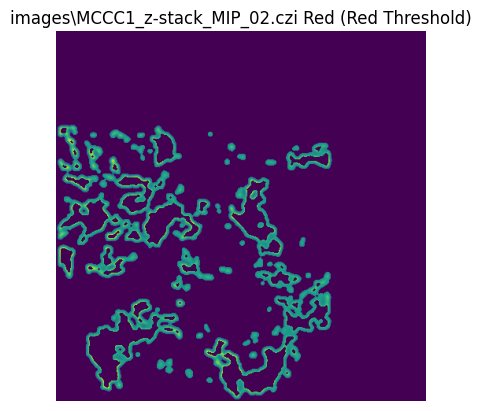

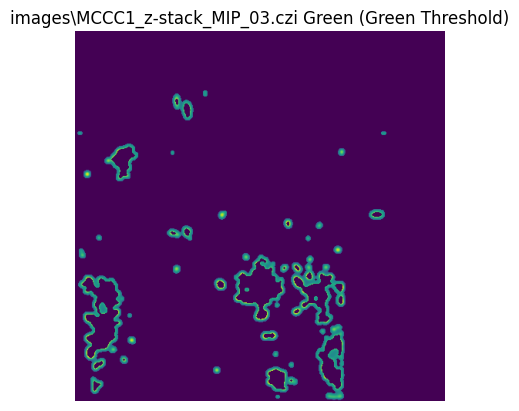

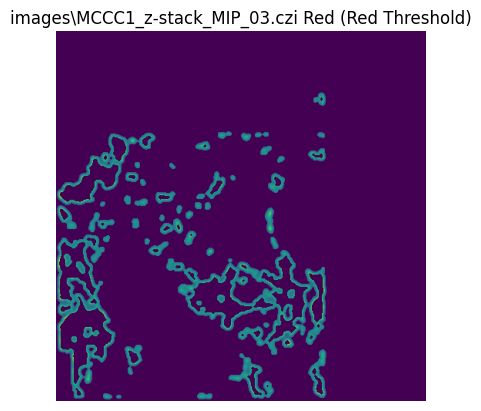

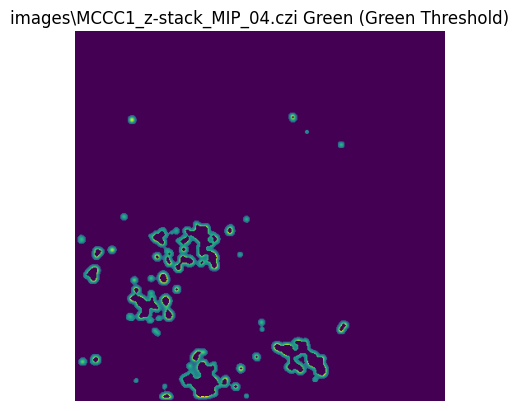

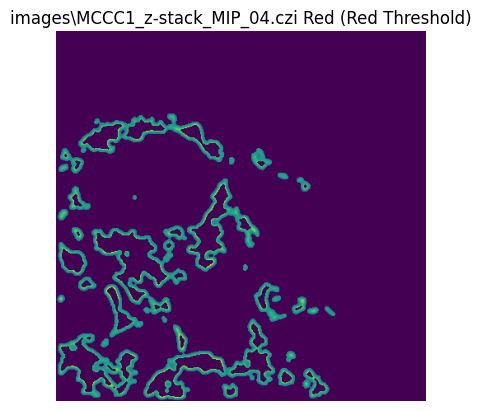

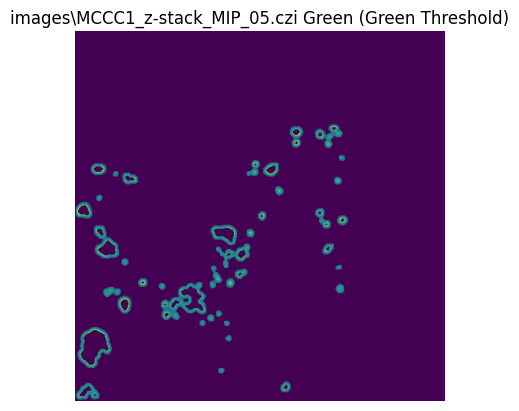

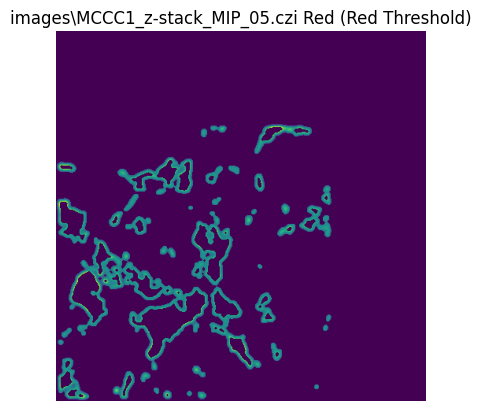

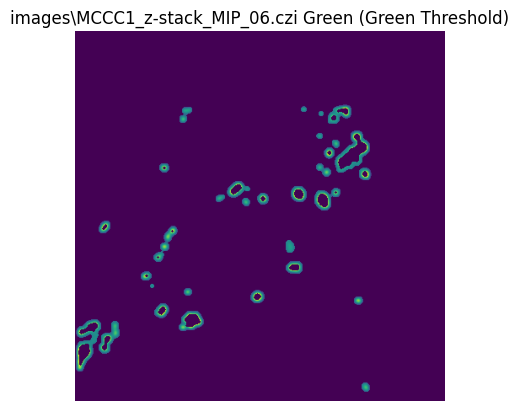

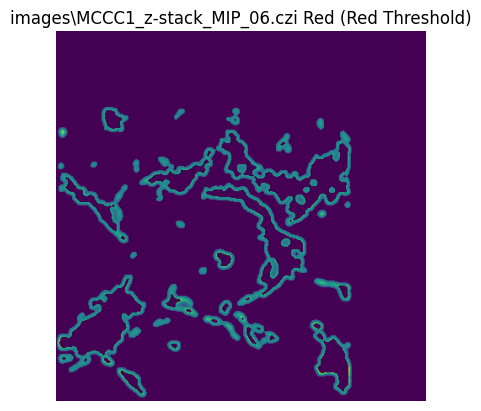

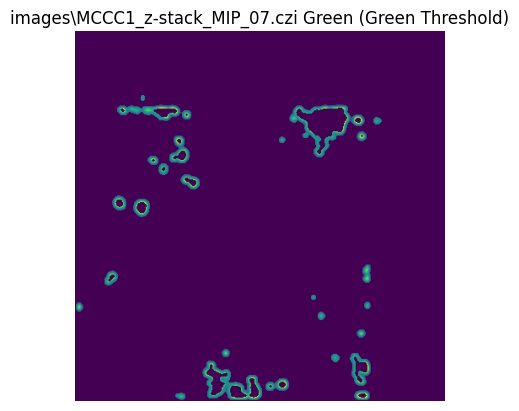

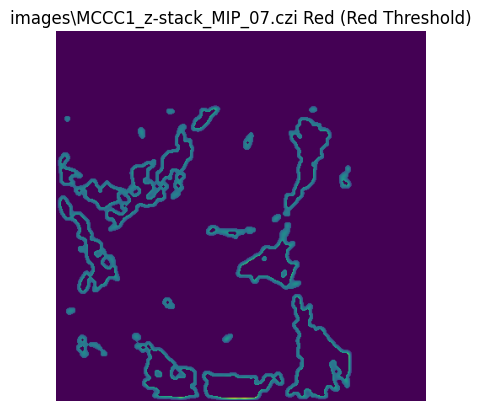

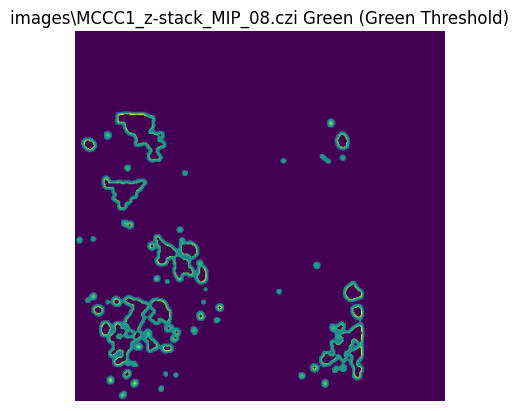

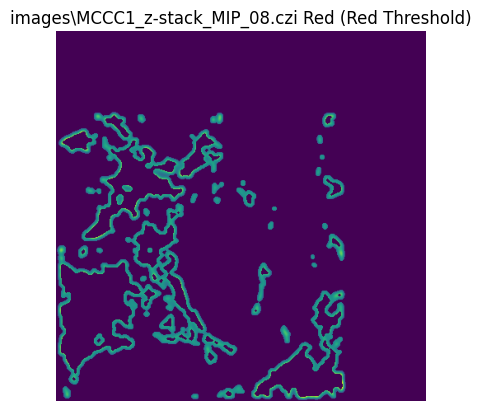

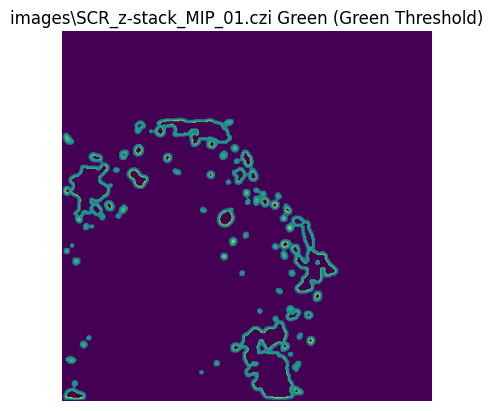

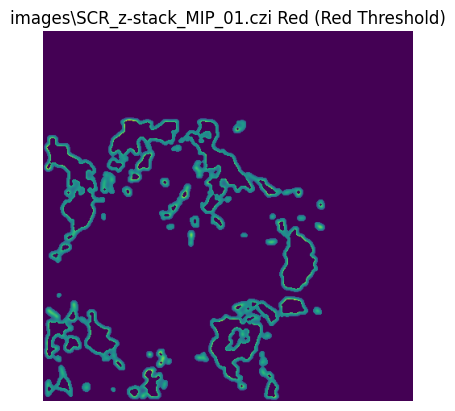

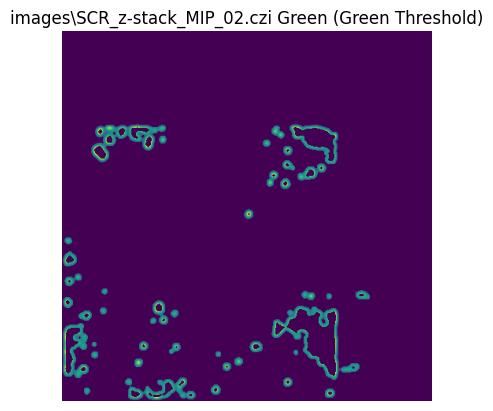

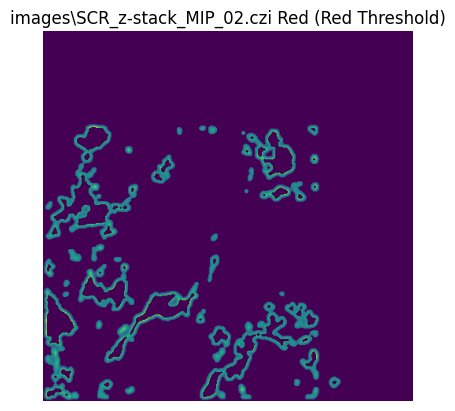

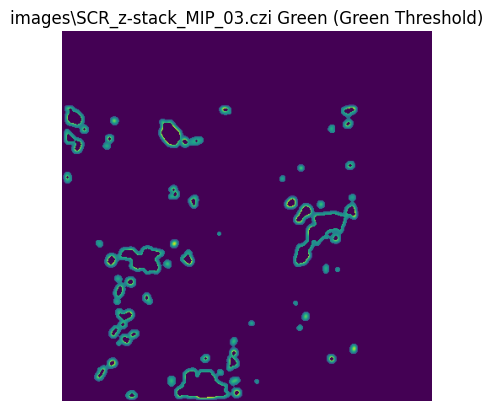

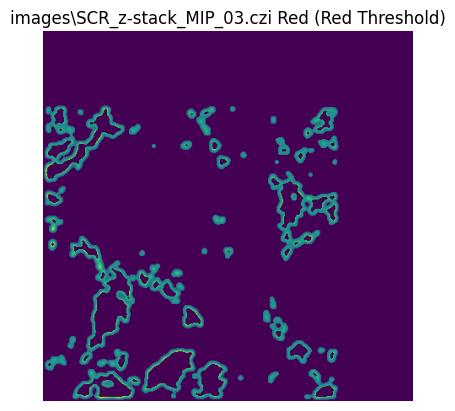

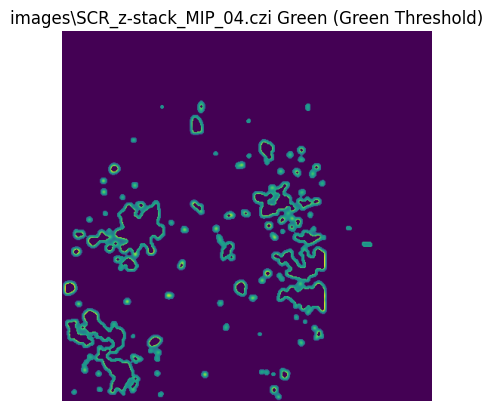

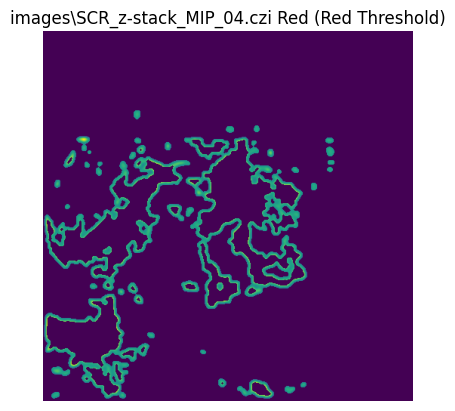

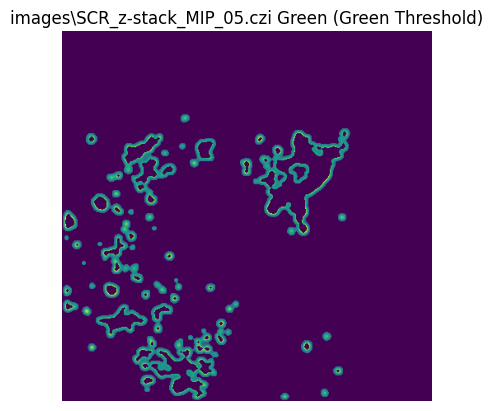

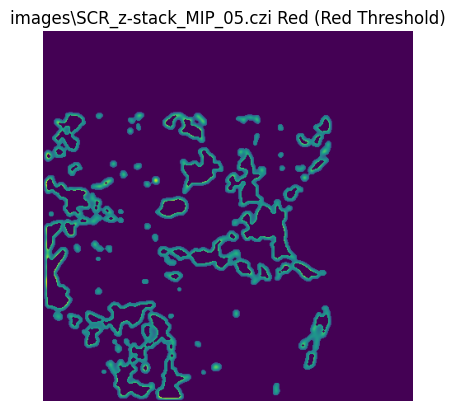

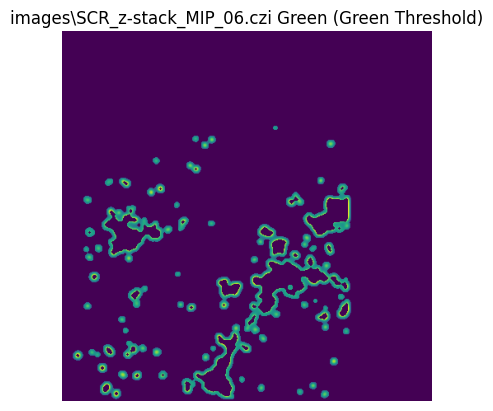

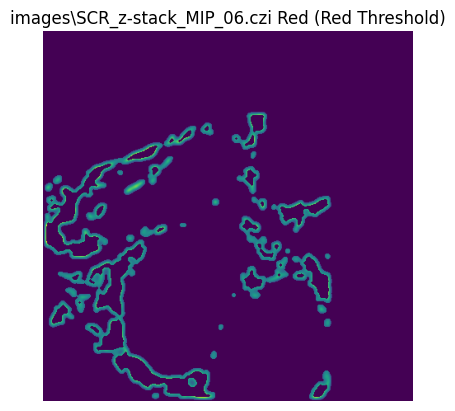

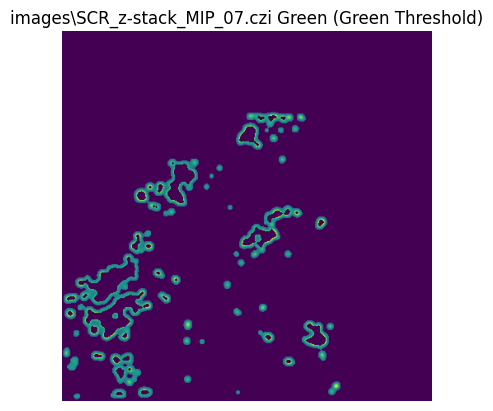

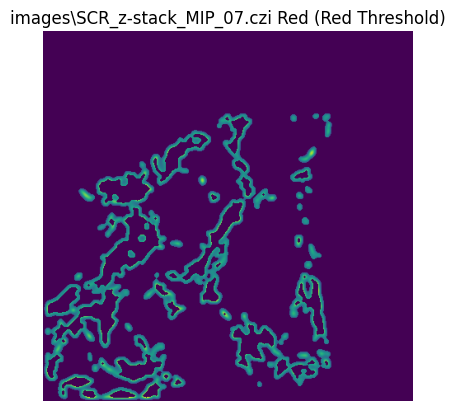

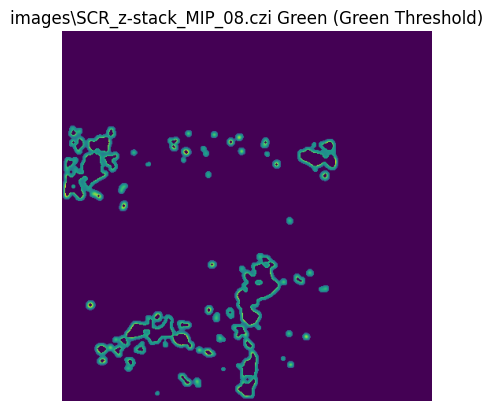

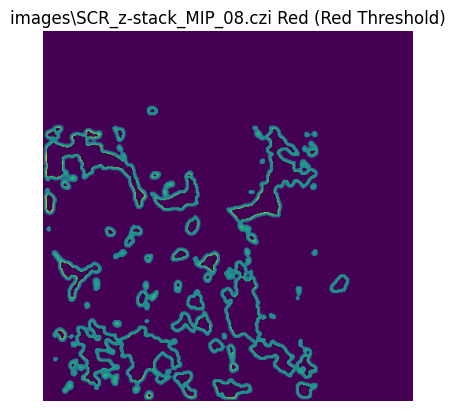

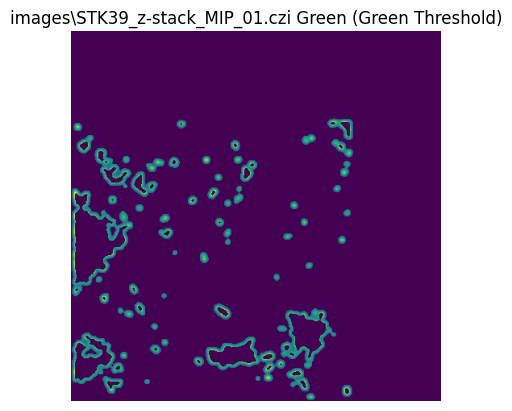

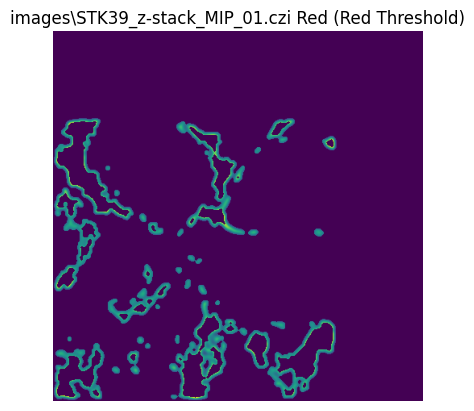

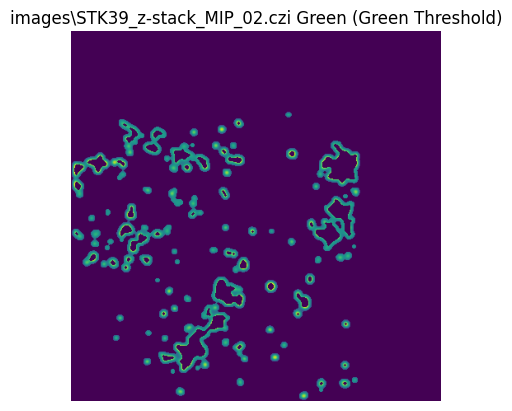

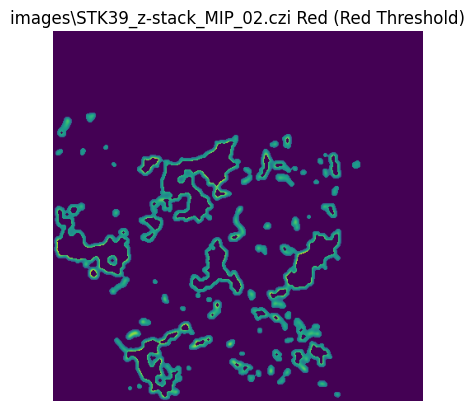

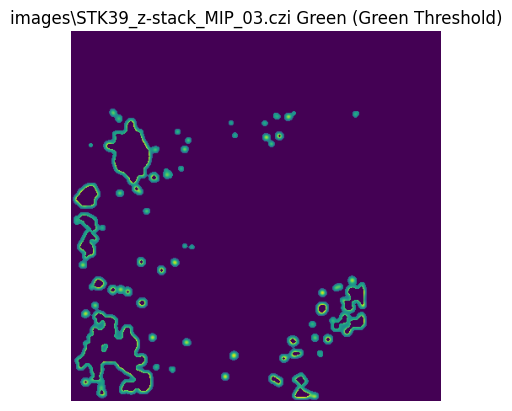

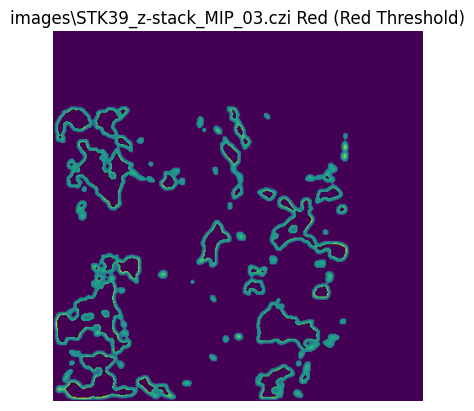

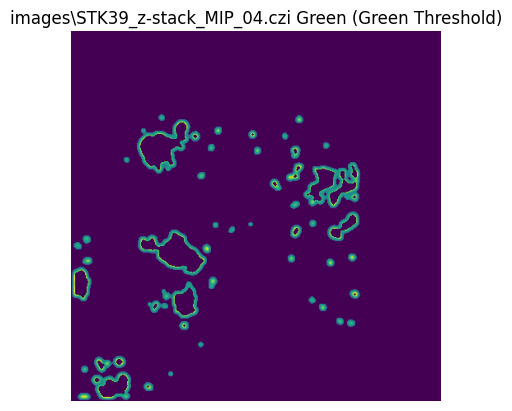

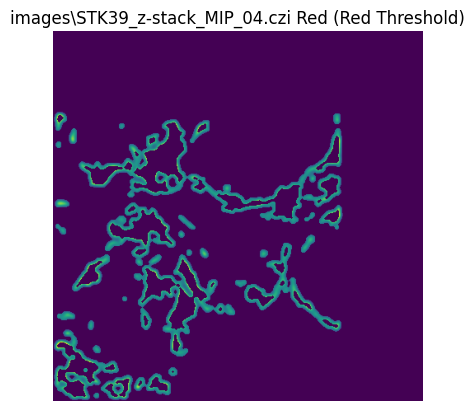

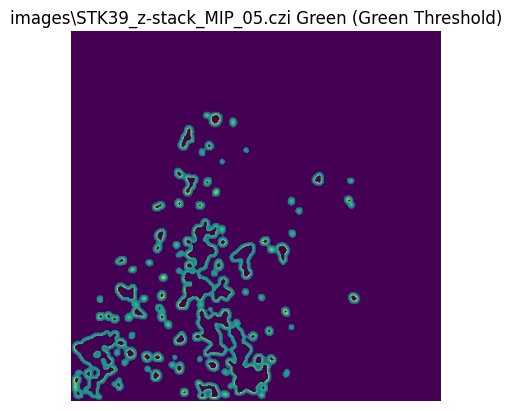

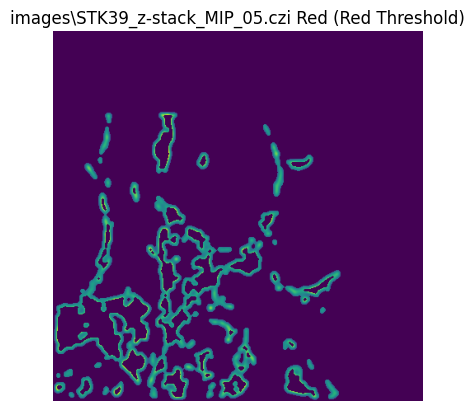

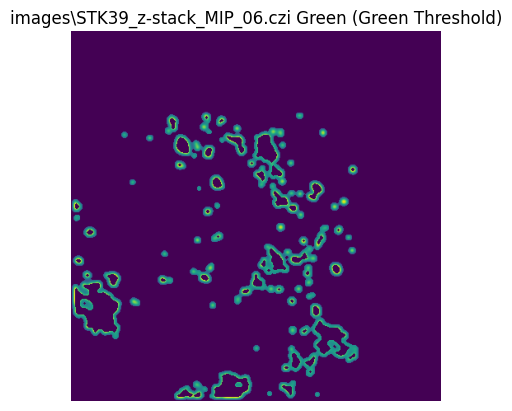

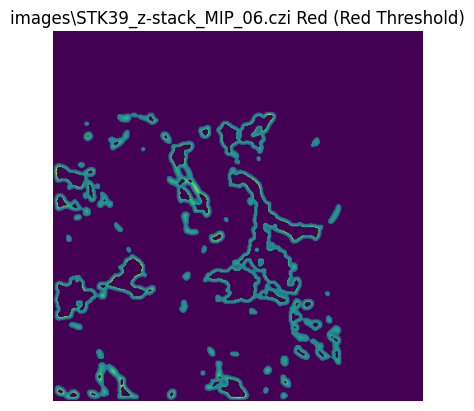

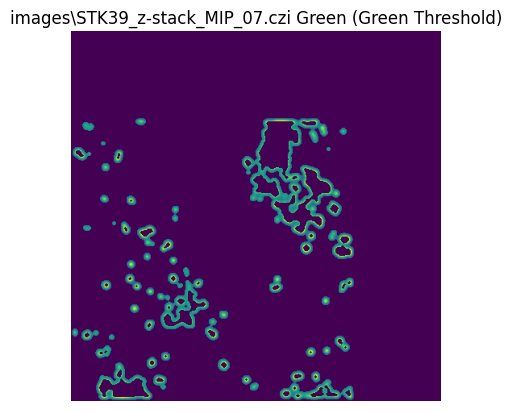

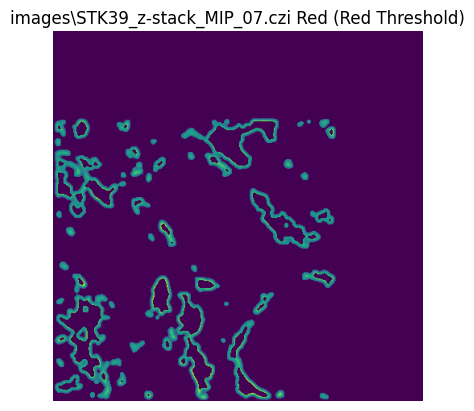

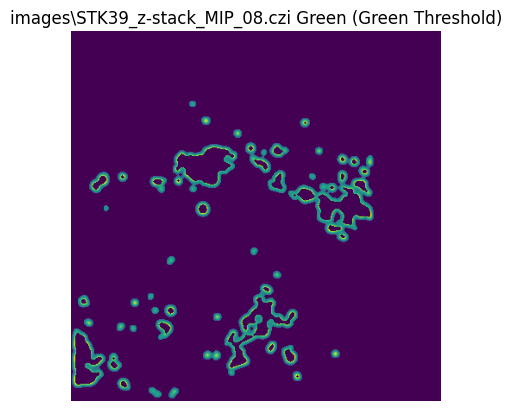

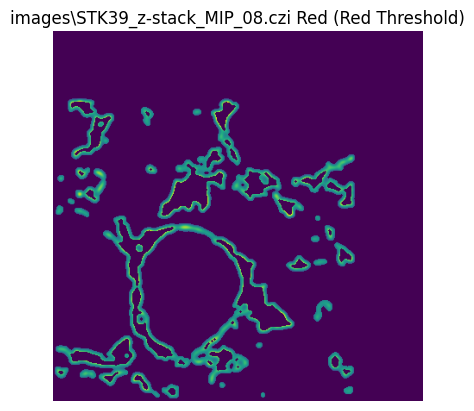

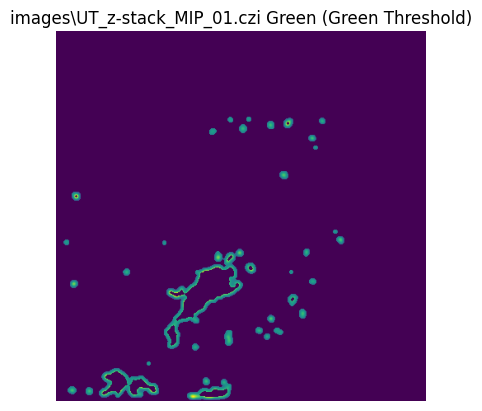

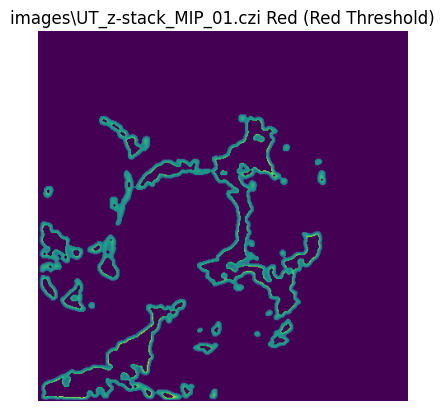

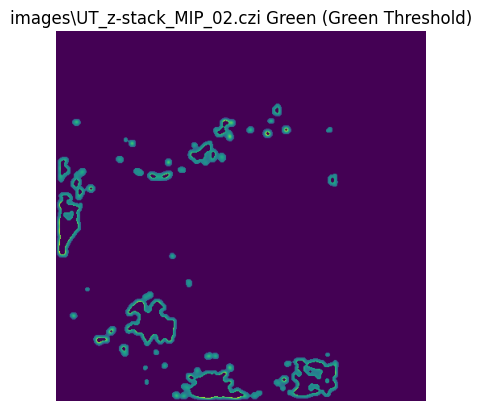

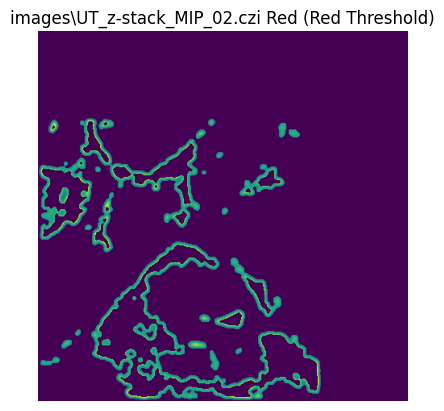

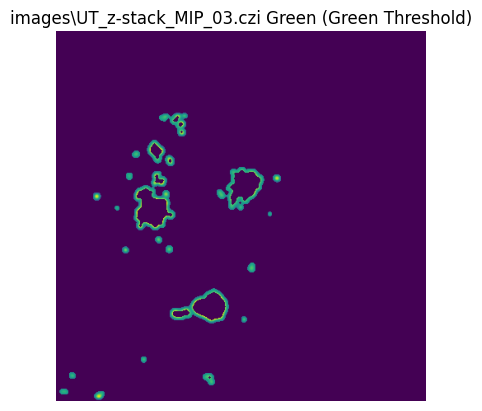

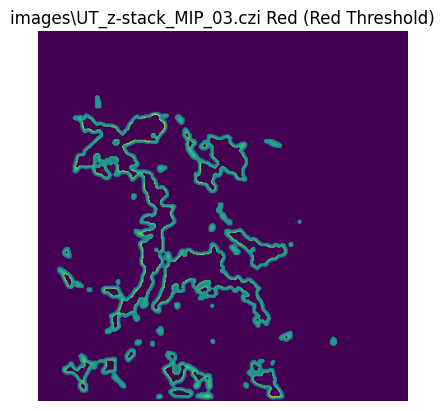

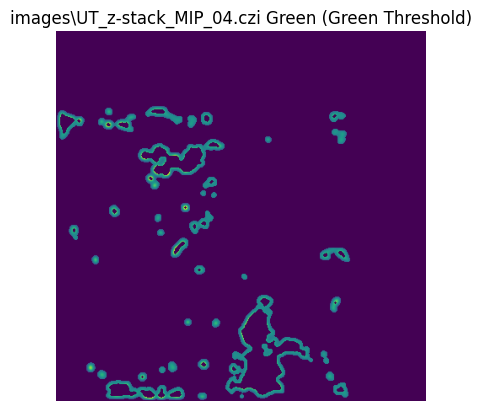

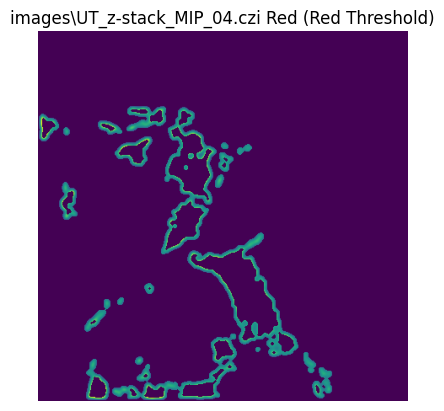

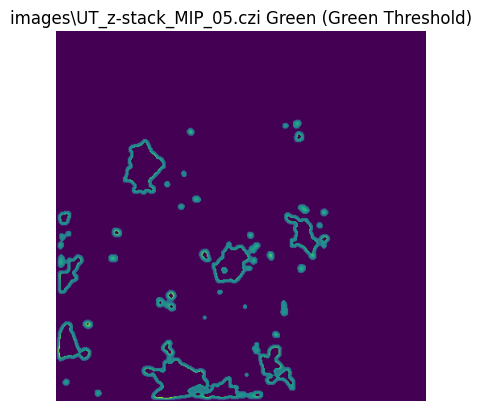

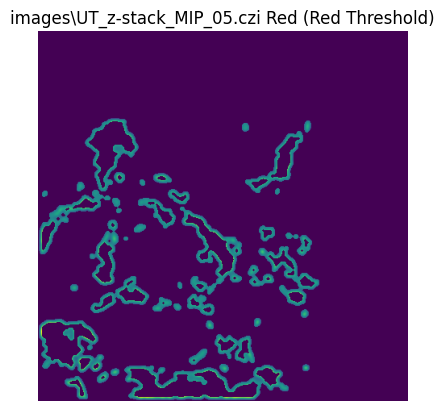

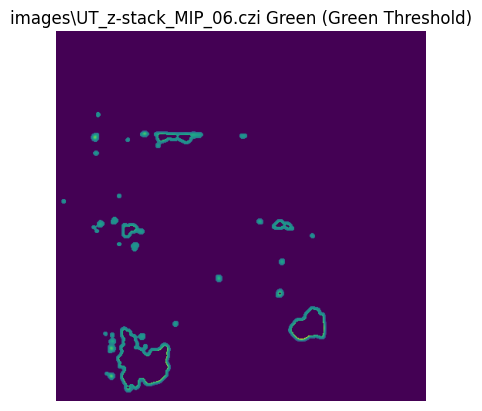

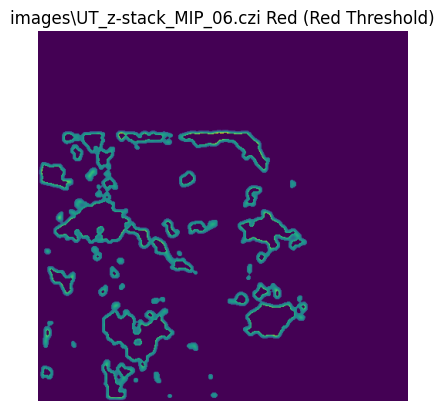

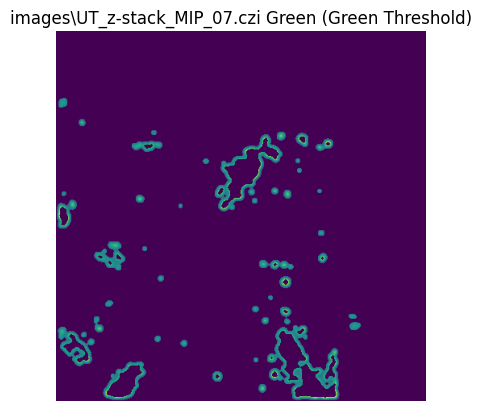

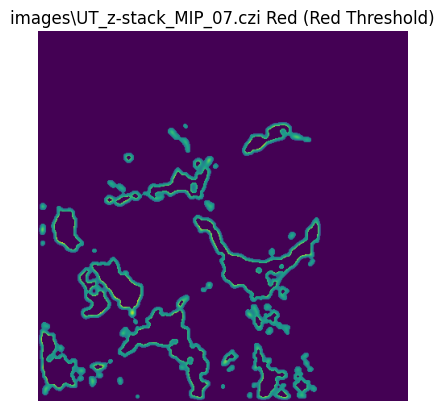

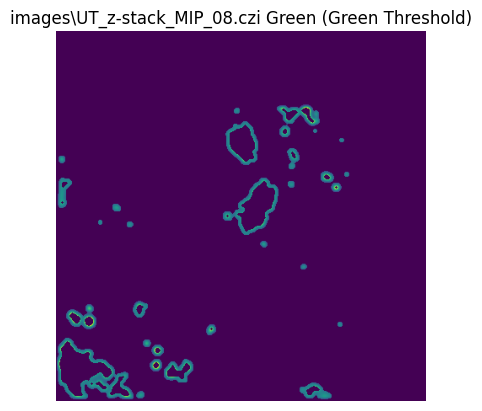

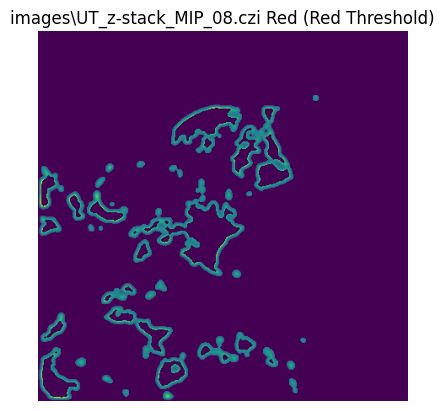

In [93]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)

    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
        green, red = extract_channels(image_squeezed)

        red_channel = gaussian(red, sigma=2)
        green_channel = gaussian(green, sigma=2)

        # Thresholding for GREEN channel (original logic)
        initial_threshold_green = threshold_otsu(green_channel)
        cells_thresholded_green = green_channel > initial_threshold_green
        cells_edges_green = sobel(cells_thresholded_green)
        cells_edges_green = binary_dilation(cells_edges_green, disk(2))
        cells_edges_green = binary_erosion(cells_edges_green, disk(1))
        labeled_image_green = label(cells_edges_green)

        # Thresholding for RED channel (new logic)
        initial_threshold_red = threshold_otsu(red_channel)
        cells_thresholded_red = red_channel > initial_threshold_red
        cells_edges_red = sobel(cells_thresholded_red)
        cells_edges_red = binary_dilation(cells_edges_red, disk(2))
        cells_edges_red = binary_erosion(cells_edges_red, disk(1))
        labeled_image_red = label(cells_edges_red)

        # Composite masks for GREEN and RED (separately)
        composite_mask_green = np.zeros_like(green_channel, dtype=bool)
        composite_mask_red = np.zeros_like(red_channel, dtype=bool)

        # Process GREEN channel regions
        for region in regionprops(labeled_image_green):
            mask = labeled_image_green == region.label
            if mask_near_border(mask):
                continue
            composite_mask_green = np.logical_or(composite_mask_green, mask)
        

        # Process RED channel regions
        for region in regionprops(labeled_image_red):
            mask = labeled_image_red == region.label
            if mask_near_border(mask):
                continue
            composite_mask_red = np.logical_or(composite_mask_red, mask)

        # Apply masks to respective channels
        green_masked_total = green_channel * composite_mask_green
        red_masked_total = red_channel * composite_mask_red

        # Display results
        display_image(green_masked_total, path, "Green (Green Threshold)")
        display_image(red_masked_total, path, "Red (Red Threshold)")

        threshold = threshold_otsu(green_channel[whole_cell > 0])




    



        
if __name__ == "__main__":
    image_folder = 'images'
    main(image_folder)